<a href="https://colab.research.google.com/github/SaeidDaliriSusefi/RiverWSE-Estimation/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import gaussian_kde
from scipy.signal import medfilt  # Importing Median filter
from scipy import interpolate

In [ ]:
Initial_file_path = "/content/photon_2022-09-06_t1174_1738864384174.csv"  # Update with actual path
Calib_file_path=

Sorting by latitude (north-south cross-section).


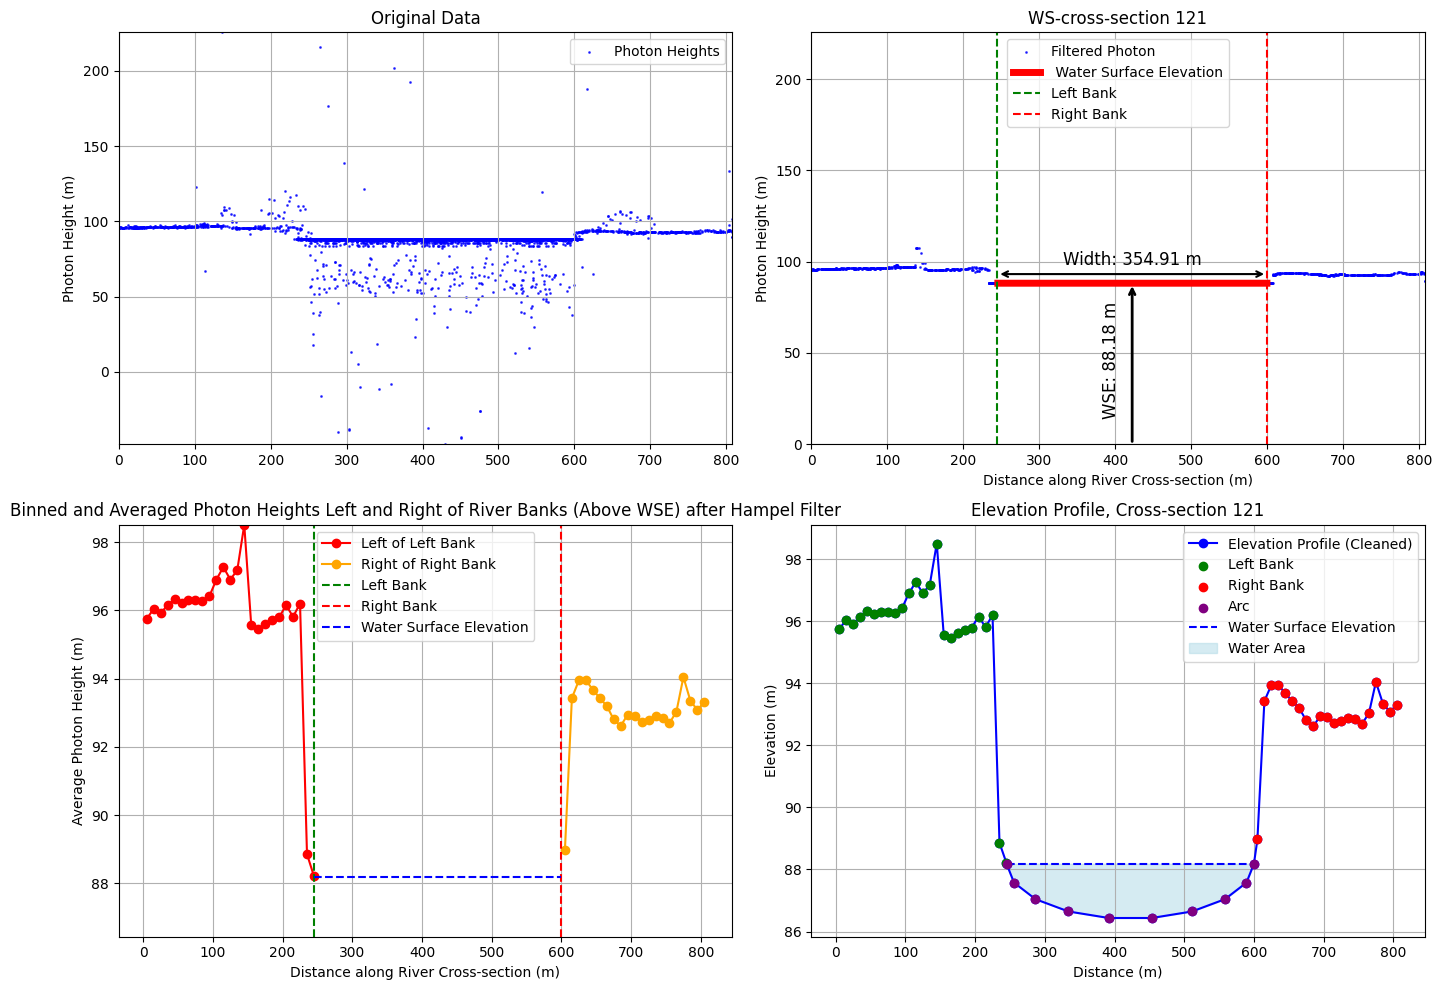

Final Cross-Section Distance Range: 0.00 m to 807.80 m
Estimated Water Surface Elevation: 88.18 meters
River Width (Percentile-Based): 354.91 meters
Data exported to elevation_profile.xlsx


In [ ]:
# Hampel filter function to remove outliers
def hampel_filter(data, window_size=20, threshold=7):
    """
    Apply the Hampel filter to remove outliers in the data.

    Parameters:
        data (array-like): The data to filter.
        window_size (int): The size of the sliding window. Must be an odd number.
        threshold (int): The threshold for identifying outliers.

    Returns:
        filtered_data (array-like): The filtered data with outliers removed.
    """
    filtered_data = data.copy()
    half_window = window_size // 2
    for i in range(half_window, len(data) - half_window):
        # Create the window of values
        window = data[i - half_window:i + half_window + 1]

        # Calculate the median and MAD of the window
        median = np.median(window)
        mad = np.median(np.abs(window - median))

        # Check if the current data point is an outlier
        if np.abs(data[i] - median) > threshold * mad:
            # Replace the outlier with the median of the window
            filtered_data[i] = median

    return filtered_data

# Load the CSV file (modify the path if needed)
df_initial = pd.read_csv(Initial_file_path)

# Extract relevant columns
latitude = df_initial.iloc[:, 1].values  # Latitude
longitude = df_initial.iloc[:, 2].values  # Longitude
photon_height = df_initial.iloc[:, 3].values  # Photon Height

# Determine sorting order (latitude vs. longitude)
lat_range = max(latitude) - min(latitude)
lon_range = max(longitude) - min(longitude)

if lat_range > lon_range:
    sorted_indices = np.argsort(latitude)  # Sort by latitude if river is mainly north-south
    print("Sorting by latitude (north-south cross-section).")
else:
    sorted_indices = np.argsort(longitude)  # Sort by longitude if river is mainly east-west
    print("Sorting by longitude (east-west cross-section).")

# Apply sorting
latitude = latitude[sorted_indices]
longitude = longitude[sorted_indices]
photon_height = photon_height[sorted_indices]

# Apply the Hampel filter to remove outliers from photon_height with a stronger threshold
stronger_filtered_photon_height = hampel_filter(photon_height, window_size=20, threshold=7)

# Apply the Median filter on top of the Hampel filter (using a window size of 5 for the median filter)
final_filtered_photon_height = medfilt(stronger_filtered_photon_height, kernel_size=5)

# Convert degrees to meters (approximate conversion factors)
lat_to_meters = 111320  # 1 degree latitude ≈ 111.32 km
lon_to_meters = 40075000 * np.cos(np.radians(np.mean(latitude))) / 360  # Adjust longitude scaling

# Compute Euclidean distance along the cross-section
cross_section_distances = np.cumsum(
    np.sqrt(np.diff(latitude) ** 2 * lat_to_meters ** 2 +
            np.diff(longitude) ** 2 * lon_to_meters ** 2)
)

# Add the first point (zero distance)
cross_section_distances = np.insert(cross_section_distances, 0, 0)


# ------------------------------ Water Surface Filtering (Using KDE) ------------------------------

# Compute Gaussian Kernel Density Estimation (KDE) for filtered photon heights
kde = gaussian_kde(final_filtered_photon_height)
photon_height_range = np.linspace(min(final_filtered_photon_height), max(final_filtered_photon_height), 1000)
density_values = kde(photon_height_range)

# Find the peak density value (mode of the distribution)
peak_height = photon_height_range[np.argmax(density_values)]

# Identify points within ±20 cm of the peak
water_surface_mask = (final_filtered_photon_height >= peak_height - 0.2) & (final_filtered_photon_height <= peak_height)
water_surface_heights = final_filtered_photon_height[water_surface_mask]
water_surface_distances = cross_section_distances[water_surface_mask]

# Compute the average water surface height (water surface elevation)
average_water_surface_height = np.mean(water_surface_heights)

# Print the estimated water surface elevation


# ------------------------------ Remove Points Below Water Surface Elevation ------------------------------

# Create a mask to remove points with height lower than the average water surface elevation (WSE)
above_water_surface_mask = final_filtered_photon_height >= average_water_surface_height

# Filter the data using the mask
filtered_above_water_surface_distances = cross_section_distances[above_water_surface_mask]
filtered_above_water_surface_heights = final_filtered_photon_height[above_water_surface_mask]



# ------------------------------ River Width Estimation (Percentile-Based) ------------------------------

# Define riverbanks using percentile-based approach
left_bank = np.percentile(water_surface_distances, 1)  # 1st percentile as left boundary
right_bank = np.percentile(water_surface_distances, 99)  # 99th percentile as right boundary

# Compute river width
river_width_percentile = right_bank - left_bank


# ------------------------------ Trimmed Water Surface Line ------------------------------

# Trim water surface line to only show within riverbanks
trimmed_mask = (cross_section_distances >= left_bank) & (cross_section_distances <= right_bank)
trimmed_distances = cross_section_distances[trimmed_mask]
trimmed_surface = np.full_like(trimmed_distances, average_water_surface_height)

# ------------------------------ Create Two Subplots in 2 Columns ------------------------------
##########################################################################################################################################################################
# Define a mask for all points to the left of the left bank
left_of_left_bank_mask = cross_section_distances < left_bank

# Extract the corresponding distances and photon heights for points to the left of the left bank
left_of_left_bank_distances = cross_section_distances[left_of_left_bank_mask]
left_of_left_bank_heights = final_filtered_photon_height[left_of_left_bank_mask]

# Define a mask for all points to the right of the right bank
right_of_right_bank_mask = cross_section_distances > right_bank

# Extract the corresponding distances and photon heights for points to the right of the right bank
right_of_right_bank_distances = cross_section_distances[right_of_right_bank_mask]
right_of_right_bank_heights = final_filtered_photon_height[right_of_right_bank_mask]

# Create a mask to filter out points with photon height lower than the average water surface elevation
left_above_water_surface_mask = left_of_left_bank_heights >= average_water_surface_height
right_above_water_surface_mask = right_of_right_bank_heights >= average_water_surface_height

# Apply the mask to filter the distances and heights for both left and right side points
left_above_water_surface_distances = left_of_left_bank_distances[left_above_water_surface_mask]
left_above_water_surface_heights = left_of_left_bank_heights[left_above_water_surface_mask]

right_above_water_surface_distances = right_of_right_bank_distances[right_above_water_surface_mask]
right_above_water_surface_heights = right_of_right_bank_heights[right_above_water_surface_mask]

# Define the bin edges (intervals of 10 meters along the river)
bin_edges = np.arange(min(cross_section_distances), max(cross_section_distances) + 10, 10)

# Calculate the average photon height for the left side (left of the left bank)
left_binned_averages = []
for i in range(len(bin_edges) - 1):
    # Create a mask for the points within the current bin range
    bin_mask = (left_above_water_surface_distances >= bin_edges[i]) & (left_above_water_surface_distances < bin_edges[i + 1])

    # Calculate the average photon height for this bin
    if np.sum(bin_mask) > 0:  # Make sure there are points in the bin
        bin_avg = np.mean(left_above_water_surface_heights[bin_mask])
    else:
        bin_avg = np.nan  # If no points in this bin, use NaN to avoid plotting issues
    left_binned_averages.append(bin_avg)

# Ensure that the first bin (at the left bank) matches the water surface elevation
left_binned_averages[0] = average_water_surface_height  # Set the leftmost bin to the average water surface elevation

# Calculate the average photon height for the right side (right of the right bank)
right_binned_averages = []
for i in range(len(bin_edges) - 1):
    # Create a mask for the points within the current bin range
    bin_mask = (right_above_water_surface_distances >= bin_edges[i]) & (right_above_water_surface_distances < bin_edges[i + 1])

    # Calculate the average photon height for this bin
    if np.sum(bin_mask) > 0:  # Make sure there are points in the bin
        bin_avg = np.mean(right_above_water_surface_heights[bin_mask])
    else:
        bin_avg = np.nan  # If no points in this bin, use NaN to avoid plotting issues
    right_binned_averages.append(bin_avg)

# Ensure that the last bin (at the right bank) matches the water surface elevation
right_binned_averages[-1] = average_water_surface_height  # Set the rightmost bin to the average water surface elevation

# Apply the Hampel filter to remove outliers (you can adjust the window_size and threshold if needed)
def hampel_filter(data, window_size=20, threshold=7):
    """
    Apply the Hampel filter to remove outliers in the data.
    """
    filtered_data = data.copy()
    half_window = window_size // 2
    for i in range(half_window, len(data) - half_window):
        window = data[i - half_window:i + half_window + 1]
        median = np.median(window)
        mad = np.median(np.abs(window - median))

        if np.abs(data[i] - median) > threshold * mad:
            filtered_data[i] = median

    return filtered_data

# Apply the Hampel filter to the photon heights for left and right sides
left_filtered_heights = hampel_filter(left_above_water_surface_heights)
right_filtered_heights = hampel_filter(right_above_water_surface_heights)

# Now proceed with binning and averaging after outlier removal

# Calculate the average photon height for the left side (left of the left bank) after Hampel filter
left_binned_averages = []
for i in range(len(bin_edges) - 1):
    bin_mask = (left_above_water_surface_distances >= bin_edges[i]) & (left_above_water_surface_distances < bin_edges[i + 1])

    if np.sum(bin_mask) > 0:  # Ensure there are points in the bin
        bin_avg = np.mean(left_filtered_heights[bin_mask])  # Use the filtered heights
    else:
        bin_avg = np.nan
    left_binned_averages.append(bin_avg)

# Calculate the average photon height for the right side (right of the right bank) after Hampel filter
right_binned_averages = []
for i in range(len(bin_edges) - 1):
    bin_mask = (right_above_water_surface_distances >= bin_edges[i]) & (right_above_water_surface_distances < bin_edges[i + 1])

    if np.sum(bin_mask) > 0:  # Ensure there are points in the bin
        bin_avg = np.mean(right_filtered_heights[bin_mask])  # Use the filtered heights
    else:
        bin_avg = np.nan
    right_binned_averages.append(bin_avg)

# Define the center and radius for the arc
arc_center_x = (left_bank + right_bank) / 2
arc_center_y = average_water_surface_height

# Set a radius for the arc (the distance from the center to the left or right bank)
arc_radius_x = (right_bank - left_bank) / 2  # Horizontal radius

# Define the vertical scaling factor (e.g., 2.0 for doubling the vertical size)
vertical_scale = 10.0  # Increase this value to stretch the arc vertically

# Calculate the vertical radius
arc_radius_y = arc_radius_x * (-vertical_scale/1000)  # Vertical radius

# Define angles for the arc from the left bank to the right bank
theta_start = np.pi  # Start at the left bank (angle 180 degrees)
theta_end = 0  # End at the right bank (angle 0 degrees)

# Generate the arc points using parametric equations
theta_values = np.linspace(theta_start, theta_end, 10)
arc_x = arc_center_x + arc_radius_x * np.cos(theta_values)
arc_y = arc_center_y + arc_radius_y * np.sin(theta_values)


# Extract the distances of the binned averages for the left and right sides
left_binned_distances = bin_edges[:-1] + 5  # Midpoint of each bin
right_binned_distances = bin_edges[:-1] + 5
left_binned_heights=left_binned_averages
right_binned_heights=right_binned_averages
arc_distances = arc_x

# Combine the left, arc, and right distances into one final_distances
left_distances = left_binned_distances  # Midpoints of each bin for the left side
arc_distances = arc_x  # X-values for the arc
right_distances = right_binned_distances  # Midpoints of each bin for the right side

# Concatenate the left, arc, and right distances into the final_distances array
final_distances = np.concatenate([left_distances, arc_distances, right_distances])

# Combine the left, arc, and right elevations into one final_elevation
left_elevation = left_binned_heights
arc_elevation = arc_y
right_elevation = right_binned_heights

# Concatenate the left, arc, and right elevations into the final_elevation array
final_elevation = np.concatenate([left_elevation, arc_elevation, right_elevation])

# Remove NaN values from final_elevation and the corresponding values in final_distances
valid_mask = ~np.isnan(final_elevation)

# Apply the mask to both final_elevation and final_distances
final_elevation_cleaned = final_elevation[valid_mask]
final_distances_cleaned = final_distances[valid_mask]



# Create a plot of final distances vs final elevations

########################################



# Create a figure and four subplots (2 rows, 2 columns)
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Find the min and max values for x and y axes
x_min = min(np.min(cross_section_distances), np.min(filtered_above_water_surface_distances))
x_max = max(np.max(cross_section_distances), np.max(filtered_above_water_surface_distances))
y_min = min(np.min(photon_height), np.min(filtered_above_water_surface_heights))
y_max = max(np.max(photon_height), np.max(filtered_above_water_surface_heights))

# Original Data Plot (top-left subplot)
axs[0, 0].scatter(cross_section_distances, photon_height, color='blue', s=1, alpha=0.7, label="Photon Heights")
axs[0, 0].set_title('Original Data')
axs[0, 0].set_ylabel("Photon Height (m)")
axs[0, 0].set_xlim(x_min, x_max)  # Set x-axis limits
axs[0, 0].set_ylim(y_min, y_max)  # Set y-axis limits
axs[0, 0].legend(loc='best')
axs[0, 0].grid(True)

# Filtered Data Plot (top-right subplot)
axs[0, 1].scatter(filtered_above_water_surface_distances, filtered_above_water_surface_heights, color='blue', s=1, alpha=0.7, label="Filtered Photon")
axs[0, 1].plot(trimmed_distances, trimmed_surface, color='red', linestyle='-', linewidth=5,
               label=f" Water Surface Elevation")
axs[0, 1].set_title('WS-cross-section 121')
axs[0, 1].set_xlabel("Distance along River Cross-section (m)")
axs[0, 1].set_ylabel("Photon Height (m)")
axs[0, 1].set_xlim(x_min, x_max)  # Set x-axis limits
axs[0, 1].set_ylim(0, y_max)  # Set y-axis limits to start from 0 and go up to the max y value

# Adding Left and Right Banks to the top-right plot
axs[0, 1].axvline(left_bank, color='green', linestyle='--', label='Left Bank')  # Left Bank
axs[0, 1].axvline(right_bank, color='red', linestyle='--', label='Right Bank')  # Right Bank

# Adding the river width with an arrow annotation in the top-right plot
axs[0, 1].annotate('', xy=(right_bank, average_water_surface_height+5), xytext=(left_bank, average_water_surface_height+5),
                   arrowprops=dict(arrowstyle='<->', color='black', lw=1.5))
axs[0, 1].text((left_bank + right_bank) / 2, average_water_surface_height + 10, f'Width: {river_width_percentile:.2f} m',
               horizontalalignment='center', fontsize=12, color='black')

# Move the WSE vertical arrow to the center of the river (top-right plot)
center_of_river = (left_bank + right_bank) / 2  # Center of the river
axs[0, 1].annotate('', xy=(center_of_river, average_water_surface_height), xytext=(center_of_river, 0),
                   arrowprops=dict(arrowstyle='->', color='black', lw=2))

# Add vertical text annotation for water surface elevation to the left of the arrow in the top-right plot
axs[0, 1].text(center_of_river - 40, average_water_surface_height-10, f'WSE: {average_water_surface_height:.2f} m',
               verticalalignment='top', fontsize=12, color='black', rotation=90)

axs[0, 1].grid(True)
axs[0, 1].legend(loc='best')




# Calculate the global y-axis limits (you can modify this based on your data)
min_y = min(min(left_binned_averages), min(right_binned_averages), min(final_elevation_cleaned))
max_y = max(max(left_binned_averages), max(right_binned_averages), max(final_elevation_cleaned))

# Third subplot (bottom-left): Binned and Averaged Photon Heights
axs[1, 0].plot(bin_edges[:-1] + 5, left_binned_averages, color='red', label='Left of Left Bank ', marker='o')
axs[1, 0].plot(bin_edges[:-1] + 5, right_binned_averages, color='orange', label='Right of Right Bank', marker='o')
axs[1, 0].axvline(left_bank, color='green', linestyle='--', label='Left Bank')
axs[1, 0].axvline(right_bank, color='red', linestyle='--', label='Right Bank')

# Add the Water Surface Elevation line (horizontal) between the left and right banks to the third subplot
axs[1, 0].plot([left_bank, right_bank], [average_water_surface_height, average_water_surface_height],
               color='blue', linestyle='--', label='Water Surface Elevation')

# Set the same y-axis limits for the third subplot
axs[1, 0].set_ylim([min_y, max_y])

# Third subplot labels and title
axs[1, 0].set_xlabel('Distance along River Cross-section (m)')
axs[1, 0].set_ylabel('Average Photon Height (m)')
axs[1, 0].set_title('Averaged Photon Heights Left and Right of River Banks (Above WSE) after Hampel Filter')
axs[1, 0].legend(loc='best')
axs[1, 0].grid(True)

# Fourth subplot (bottom-right): Elevation Profile
axs[1, 1].plot(final_distances_cleaned, final_elevation_cleaned, label='Elevation Profile (Cleaned)', color='blue', marker='o')
axs[1, 1].scatter(left_binned_distances, left_binned_heights, color='green', label='Left Bank', zorder=5)
axs[1, 1].scatter(right_binned_distances, right_binned_heights, color='red', label='Right Bank', zorder=5)
axs[1, 1].scatter(arc_distances, arc_elevation, color='purple', label='Arc', zorder=5)
axs[1, 1].plot([left_bank, right_bank], [average_water_surface_height, average_water_surface_height],
               color='blue', linestyle='--', label='Water Surface Elevation')
axs[1, 1].fill_between(final_distances_cleaned, final_elevation_cleaned, average_water_surface_height,
                       where=(final_elevation_cleaned < average_water_surface_height),
                       interpolate=True, color='lightblue', alpha=0.5, label='Water Area')

# Fourth subplot labels and title
axs[1, 1].set_xlabel('Distance (m)')
axs[1, 1].set_ylabel('Elevation (m)')
axs[1, 1].set_title('Elevation Profile, Cross-section 121')
axs[1, 1].grid(True)
axs[1, 1].legend(loc='best')

# Adjust layout to avoid overlapping elements
plt.tight_layout()

# Show the plot
plt.show()



# Create a DataFrame with cleaned distances and elevations
data = {
    'Distance (m)': final_distances_cleaned,
    'Elevation (m)': final_elevation_cleaned
}

df = pd.DataFrame(data)

# Export to Excel
output_file = "elevation_profile.xlsx"
df.to_excel(output_file, index=False, engine='openpyxl')


# Print confirmation
print(f"Final Cross-Section Distance Range: {min(cross_section_distances):.2f} m to {max(cross_section_distances):.2f} m")
print(f"Estimated Water Surface Elevation: {average_water_surface_height:.2f} meters")
print(f"River Width (Percentile-Based): {river_width_percentile:.2f} meters")
print(f"Data exported to {output_file}")


# Calibration elevation